# Hidden Markov Model

La dependencia temporal es caracterizada en forma matemática por las redes Bayesianas, en las cuales los valores futuros solamente dependen de los valores recientemente observados. Tal como en redes Bayesianas con probabilidades discretas, tambi\'en es posible estudiar secuencias temporales discretas.

Estas secuencias se dan en muchas problemas en que necesitamos clasificar el estado de un proceso (oculto o latente) $Z$ que toma valores (discretos o cont\'inuos) a los que tenemos acceso a través de  variables observadas $X$.  

Sin embargo, si sabemos que el proceso $Z$ tiene la propiedad de Markov de primer orden $p(z_k \vert z_{k-1},\ldots,z_1)=p(z_k \vert z_{k-1})$ y que las observaciones $X$ son independientes entre si y solamente dependen de la variable oculta.

## Reconocimiento del Habla

Para demostrar la utilidad del algoritmo utilizamos el modelo HMM para reconocer palabras de una misma persona (https://code.google.com/p/hmm-speech-recognition/downloads/list). 

En este caso, se utiliza un mecanismo simple de detección de peaks de frecuencia y luego se clasifica los archivos de acuerdo al criterio de máxima probabilidad.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!ls audio

apple     banana    kiwi      lime      orange    peach     pineapple


In [8]:
validation_files=list()
with open("validation_list.txt", "r") as fp:
    while True:
        line = fp.readline()
        validation_files.append(line)
        if not line:
            break

In [9]:
import os

train_fpaths = []
train_labels = []
train_spoken = []

val_fpaths = []
val_labels = []
val_spoken = []
#data_subset=['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
data_subset=['apple', 'banana']

for f in os.listdir('audio'):
    if f in data_subset:
        for w in os.listdir('audio/' + f):
            if f + '/' + w not in validation_files:
                train_fpaths.append('audio/' + f + '/' + w)
                train_labels.append(f)
                if f not in train_spoken:
                    train_spoken.append(f)
            else:
                val_fpaths.append('audio/' + f + '/' + w)
                val_labels.append(f)
                if f not in val_spoken:
                    val_spoken.append(f)
print('Training Words spoken:', train_spoken)
print('Validation Words spoken:', train_spoken)

Training Words spoken: ['apple', 'banana']
Validation Words spoken: ['apple', 'banana']


Los datos contienen 7 palabras pronunciadas por una misma persona y cada palabra se repite 15 veces, dando un total de 105 archivos. Luego, los archivos se cargan en una matriz de datos y se agrega un vector de etiqueta para identificar a qué palabra corresponde cada archivo.


## Procesamiento de Audio

La Densidad Espectral de una señal es una función matemática que nos informa de cómo está distribuida la potencia de dicha señal sobre las distintas componentes de frecuencias sobre las que está formada.


In [7]:
import scipy

def stft(x, fftsize=64, overlap_pct=.5):   
    #Modified from http://stackoverflow.com/questions/2459295/stft-and-istft-in-python
    hop = int(fftsize * (1 - overlap_pct))
    w = np.hanning(fftsize + 1)[:-1]    
    raw = np.array([np.fft.rfft(w * x[i:i + fftsize]) for i in range(0, len(x) - fftsize, hop)])
    return raw[:, :(fftsize // 2)]

El espectrograma consiste en utilizar un determinado número de muestras por medio de una ventana temporal, con un tamaño específico. A continuación se hace el cálculo del contenido frecuencial de las muestras puestas en ventana, y se representan en una gráfica en tres dimensiones.

Seguidamente se desplaza la ventana a lo largo del tiempo de la señal, para escoger otro número de muestras diferentes, se vuelve a calcular el contenido frecuencial y se vuelve a representar en la misma gráfica que la anterior. Esta operación se repite sucesivamente a lo largo de la señal.

La suma de la representación de las transformadas de Fourier de las ventanas consecutivas, aporta información en el dominio frecuencial de la señal, y de la variación de la energía y la frecuencia en función del tiempo.

Una vez puesta en ventana la señal, se calcula de la Transformada de Fourier de Tiempo Reducido (STFT) del conjunto de muestras puestas en ventana. El STFT es un método de procesamiento de señales no estacionarias en las que las características estadísticas varían en función del tiempo. El STFT extrae varias tramas de una señal que son analizadas en cada uno de los desplazamientos de la ventana a lo largo del tiempo.

El desplazamiento de la ventana puede ser solapado para asegurar que las discontinuidades que se producen entre tramas no pasen por alto y se analicen en el desplazamiento de la trama siguiente, a este solapamiento de tramas también se le conoce como overlap

(3158,)
(3529,)
(3529,)


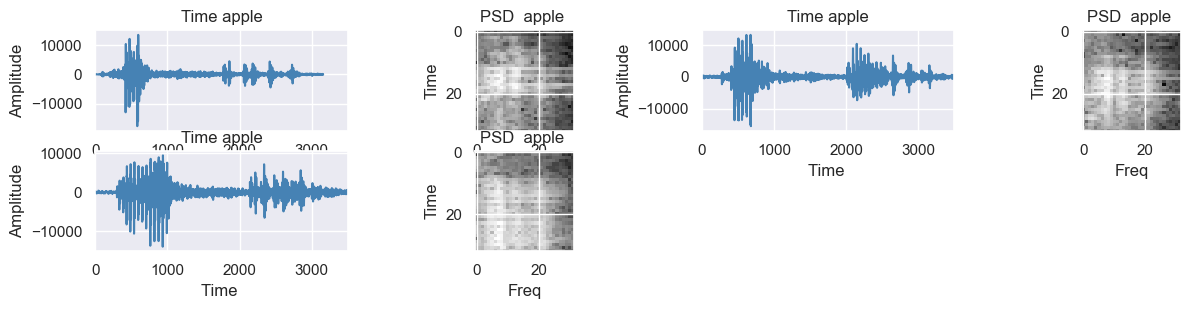

In [10]:
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

speaker=[0,1,2]
i=1
plt.figure(1, figsize=(15, 6))
for s in speaker:
    (rate,data) = wav.read(train_fpaths[s])
    print(data.shape)
    plt.subplot(4, 4, i)
    plt.plot(data, color='steelblue')
    plt.title('Time %s'%train_labels[s])
    plt.xlim(0, 3500)
    plt.xlabel('Time ')
    plt.ylabel('Amplitude')
    i=i+1
    # + 1 to avoid log of 0
    log_freq = 20 * np.log1p(np.abs(stft(data)))
    plt.subplot(4, 4, i)
    plt.imshow(log_freq, cmap='gray', interpolation=None)
    plt.xlabel('Freq')
    plt.ylabel('Time')
    plt.ylim(log_freq.shape[1])
    plt.title('PSD  %s '%train_labels[s])
    i=i+1

(3901,)
(3716,)
(4644,)


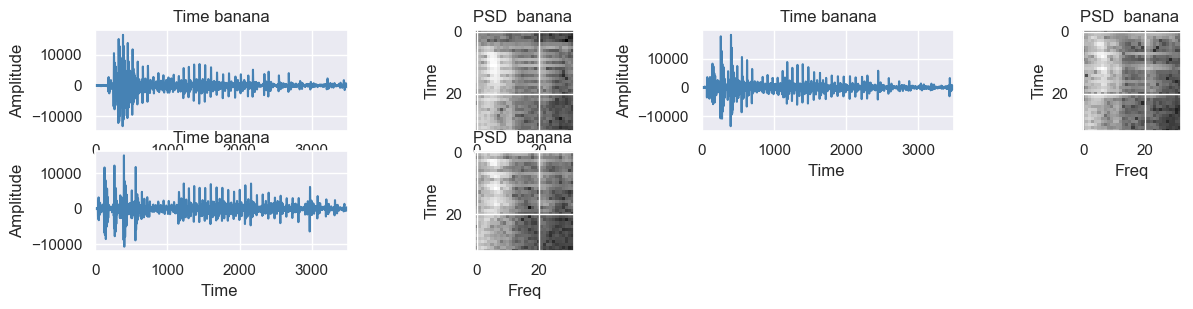

In [11]:
speaker=[15,16,17]
i=1
plt.figure(1, figsize=(15, 6))
for s in speaker:
    (rate,data) = wav.read(train_fpaths[s])
    print(data.shape)
    plt.subplot(4, 4, i)
    plt.plot(data, color='steelblue')
    plt.title('Time %s'%train_labels[s])
    plt.xlim(0, 3500)
    plt.xlabel('Time ')
    plt.ylabel('Amplitude')
    i=i+1
    # + 1 to avoid log of 0
    log_freq = 20 * np.log1p(np.abs(stft(data)))
    plt.subplot(4, 4, i)
    plt.imshow(log_freq, cmap='gray', interpolation=None)
    plt.xlabel('Freq')
    plt.ylabel('Time')
    plt.ylim(log_freq.shape[1])
    plt.title('PSD  %s '%train_labels[s])
    i=i+1

Para evaluar las probabilidades no se usan directamente estos parámetros de energía sino que se les somete antes a unas transformaciones para adaptarlos a las hipótesis que hacen los modelos estadísticos de las unidades del habla. En primer lugar, se comprime la amplitud de las energías calculando su logaritmo a fin de obtener valores con distribuciones estadísticas más parecidas a las gaussianas que suponen los modelos usados en el reconocimiento. Otra razón de peso para usar logaritmos es el carácter aditivo que pasan a tener las distorsiones que, introducidas por el micrófono o la línea telefónica, son multiplicativas en el dominio lineal. Al presentarse en forma de suma se pueden eliminar de manera mucho más fácil.
Las energías logarítmicas de bandas cercanas están correlacionadas con fuerza, mientras que los modelos de Markov ocultos típicos suponen que los parámetros no guardan correlación estadística entre ellos. Para eliminar la correlación se suele llevar a cabo la transformación coseno discreta que, aplicada al conjunto de energías de un tramo (unas 24) entrega los denominados coeficientes cepstrales, de los que sólo hace falta conservar los primeros (unos 12), lo cual representa una ventaja adicional. Se han propuesto unos parámetros alternativos a dichos coeficientes, que tampoco están correlacionados y, a diferencia de ellos, tienen la ventaja de ubicarse en frecuencia. Estos parámetros, unos 12 de forma típica, se obtienen de una manera muy simple, restando cada dos energías logarítmicas no consecutivas (la 1ª y la 3ª, la 2ª y la 4ª, etc.), por lo que son medidas de pendiente espectral, característica que ha mostrado ser un buen correlato perceptivo.

# Descriptores MFCC

In [12]:
!pip install python_speech_features
!pip install hmmlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.7/192.7 kB 5.9 MB/s eta 0:00:00


In [13]:
train_fpaths[0]

'audio/apple/apple07.wav'

(5, 26)


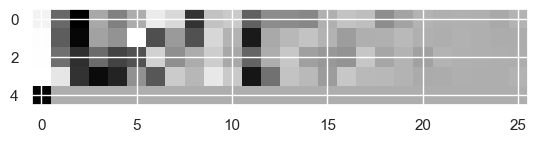

In [20]:
from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav

(rate,sig) = wav.read(train_fpaths[0])
mfcc_feat = mfcc(sig,rate,numcep=26,winstep=0.1)
fbank_feat = logfbank(sig,rate)
print(mfcc_feat.shape)
plt.imshow(mfcc_feat, cmap='gray', interpolation=None)

(6, 26)


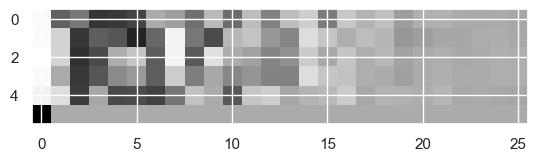

In [22]:
(rate,sig) = wav.read(train_fpaths[15])
mfcc_feat = mfcc(sig,rate,numcep=26,winstep=0.1)
fbank_feat = logfbank(sig,rate)
print(mfcc_feat.shape)
plt.imshow(mfcc_feat, cmap='gray', interpolation=None)

In [23]:
def gen_features_labels(fpaths,labels,num_features=13,win_size=0.01):
    features={label:list() for label in np.unique(labels)}
    lengths={label:list() for label in np.unique(labels)}
    for path,label in zip(fpaths,labels):
        (rate,sig) = wav.read(path)
        mfcc_feat = mfcc(sig,rate,numcep=num_features,winstep=win_size)
        features[label].append(mfcc_feat)
        lengths[label].append(mfcc_feat.shape[0])
    return features,lengths


In [24]:
train_features,train_lengths=gen_features_labels(train_fpaths,train_labels,num_features=26,win_size=0.01)

In [25]:
train_lengths

{'apple': [38, 43, 43, 35, 42, 38, 40, 43, 42, 33, 41, 40, 36, 44, 42],
 'banana': [48, 45, 57, 42, 52, 51, 52, 43, 54, 54, 50, 57, 55, 45, 51]}

In [26]:
max_len=np.max([train_lengths[key] for key in train_lengths.keys()])

In [27]:
extended_features=list()
labels_dict=dict()
count=0
for key,raw_features in train_features.items():
    features=np.stack([ np.pad(feature,((0,max_len-feature.shape[0]),(0,0)),mode='edge') for feature in raw_features])
    extended_features.append(features)
    labels_dict[key]=count
    count+=1

In [28]:
extended_features=np.stack(extended_features)

In [29]:
extended_features.shape

(2, 15, 57, 26)

In [31]:
from hmmlearn import hmm

def gen_models(train_features,train_labels,train_lengths,n_components=4,covariance_type='diag'):
    models={label:hmm.GaussianHMM(n_components=n_components, covariance_type=covariance_type) 
            for label in np.unique(train_labels)}
    scores=list()
    for label in np.unique(train_labels):
        data_sample=np.concatenate(train_features[label])
        models[label].fit(data_sample,lengths=train_lengths[label])
        score=models[label].score(data_sample)
        print('labels : {0}, score : {1:.2f}'.format(label,score))
        scores.append(score)
    return models,np.mean(scores)

In [32]:
model_order=range(4,12)
model_covariance=['diag','tied','full']
max_score=-np.inf

for i in model_order:
    for k in model_covariance:
        print('----------------------')
        print('model order : {0}, covariance : {1}'.format(i,k))
        models,mean_score=gen_models(train_features,train_labels,train_lengths,n_components=i,covariance_type=k)
        if mean_score>max_score:
            max_score=mean_score
            best_config=dict({'n_components':i,'covariance_type':k})

----------------------
model order : 4, covariance : diag
labels : apple, score : -40489.90
labels : banana, score : -49416.48
----------------------
model order : 4, covariance : tied
labels : apple, score : -40371.30
labels : banana, score : -48170.61
----------------------
model order : 4, covariance : full
labels : apple, score : -38911.61
labels : banana, score : -46068.04
----------------------
model order : 5, covariance : diag
labels : apple, score : -40055.02
labels : banana, score : -48943.92
----------------------
model order : 5, covariance : tied
labels : apple, score : -40265.91
labels : banana, score : -47675.41
----------------------
model order : 5, covariance : full
labels : apple, score : -38197.24
labels : banana, score : -45509.89
----------------------
model order : 6, covariance : diag
labels : apple, score : -39998.70
labels : banana, score : -50060.18
----------------------
model order : 6, covariance : tied
labels : apple, score : -39851.86
labels : banana, sc

In [33]:
best_config

{'n_components': 11, 'covariance_type': 'full'}

In [34]:
models,mean_score=gen_models(train_features,train_labels,train_lengths,
                             **best_config)
        

labels : apple, score : -32634.08
labels : banana, score : -42510.25


In [35]:
def test_class(models,features):
    num_samples=len(features)
    predicted_classes=list()
    scores={label:list() for label in models.keys()}
    for i in range(num_samples):
        for label,model in models.items():
            scores[label].append(model.score(features[i]))
    return scores

In [36]:
import pandas as pd

def predict_class(models,features,spoken):
    total_labels=list()
    total_preds=list()
    for word in features.keys():
        phi=test_class(models,features[word])
        df=pd.DataFrame(phi)
        y_pred=np.argmax(df.to_numpy(),axis=1)
        labels=np.repeat(spoken.index(word),len(features[word]))
        total_labels.append(labels)
        total_preds.append(y_pred)
    return np.concatenate(total_labels),np.concatenate(total_preds)

In [37]:
y_pred,y_true=predict_class(models,train_features,train_spoken)

In [38]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=train_spoken))


              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        15
      banana       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



# Tarea 

En esta tarea Ud. debe implementar el modelo HMM para el reconocimiento de 9 palabras distintas. El conjunto de datos a utilizar son parte de la competencia de Kaggle https://www.kaggle.com/datasets/alanchn31/free-spoken-digits

En la tarea Ud. debe seguir los pasos de la metodología CRISP-DM para el análisis de datos, por lo tanto se evaluará cada una de las siguientes fases:

## Fase 1 Entendimiento del Problema (5%)

Esta fase se centra en la comprensión de los objetivos del proyecto y los requisitos desde una perspectiva de negocio, a continuación, convertir ese conocimiento en una definición de una solución de minería datos y un plan preliminar para lograr los objetivos del negocio.

Las tareas de esta fase con las siguientes:

1. Determinar los objetivos del problema: comprender completamente desde la perspectiva del negocio 
    lo que el cliente realmente quiere. Además, se deben identificar factores importantes que puedan influir
    en el desarrollo del proyecto, al principio del mismo. En resumen evitar gastar mucho tiempo respondiendo
    correctamente a las preguntas de negocio incorrectas.

2. Elaborar el plan del proyecto: construir el plan para alcanzar los objetivos de minería de datos y
    los objetivos de negocio. Este plan debe describir las actividades y pasos a seguir durante el resto del
     proyecto, incluyendo la selección inicial de herramientas y tecnologías.

## Fase 2 Entendimiento de los Datos (5%)

Esta fase se inicia con una primera recopilación de datos y procede con las actividades específicas a fin de familiarizarse con los datos, para identificar problemas de calidad de los datos, primero para descubrir una visión de los datos o para detectar subconjuntos interesantes para formar las hipótesis de información oculta.

Las tareas de esta fase con las siguientes:

1. Recopilar los Datos iniciales: obtener los datos relevantes para este proyecto. Puede ser necesario 
    cargar estos datos para poder revisarlos bien y lograr entender en que estado se encuentran.

2. Descripción de los Datos: describir los datos, sus propiedades y sus medidas. 


## Fase 3 Preparación de los datos (20%)

Cubre todas las actividades encaminadas a construir los datos finales a partir de los datos en bruto. Las tareas de preparación de datos probablemente se realizan varias veces, en diferentes ordenes. Sus tareas incluyen la tabla, registro y selección de atributos, así como la transformación y limpieza de datos para herramientas de modelado. 

Las tareas de esta fase con las siguientes:

1. Seleccionar los Datos: Decidir sobre los datos que deben utilizarse para el análisis. Incluir criterios 
    de pertinencia de los datos para los objetivos, la calidad y técnicas tales como las limitaciones de volumen 
    de datos o tipos de datos. Esta tarea Cubre la selección de atributos, así como la selección de registros en 
    una tabla.

2. Limpieza de los datos: aquí buscamos elevar a calidad de los datos al nivel requerido por las técnicas de
    BI seleccionadas en el proyecto.

3. Construcción de los datos: tarea orientada a la construcción o cálculo de los atributos calculados 
    o nuevos registros requeridos por el modelo de gestión y no provisto por los datos brutos u operacionales.

4. Integración de Datos: tarea orientada a la integración de los datos de gestión generados a los modelos.

5. Aplicar formatos a los datos.
    

## Fase 4 Modelamiento (40%)

En esta fase varias técnicas de modelamiento son seleccionadas y aplicadas, y sus parámetros son calibrados buscando los valores óptimos. Típicamente, existen varias técnicas para resolver un mismo problema de minería de datos. Algunas técnicas tienen requerimientos específicos en la forma de los datos. Por esto a menudo hay que volver a la fase de preparación de datos en estos cosos.

Las tareas de esta fase con las siguientes:

1. Seleccionar la técnica de modelamiento

2. Construcción del modelo de pruebas

3. Implementación y ajuste del modelo

4. Evaluación del modelo

## Fase 5 Evaluación  (30%)

A estas alturas del proyecto ya se han construido el o los modelos los que aparenta ser correctos, desde la perspectiva del análisis de datos. Antes de proceder a la instalación final del modelo, es importante una evaluación a fondo del modelo y los pasos seguidos para su implementación para estar seguro que cumple con los objetivos de negocio. El objetivo clave es determinar si hay algún asunto de negocios que no se haya tratado con la suficiente profundidad. Al final de esta etapa se debe tener la certeza que los objetivos de negocio fueron alcanzados.

1. Evaluación de los resultados

2. Revisión del proceso

3. Determinar los próximos pasos